# ベイズオンライン変化点検知（BOCPD）デモ

このノートブックでは、BOCPDライブラリの基本的な使い方と可視化を示します。

## 1. セットアップ

In [1]:
# notebooksディレクトリから実行する場合のパス設定
import sys
from pathlib import Path

# プロジェクトルートをパスに追加（notebooks/から親ディレクトリへ）
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_fontja
from bocpd import BOCPD, GaussianModel, ConstantHazard
from bocpd.utils import plot_run_length_history

# プロットの設定
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(f"Project root: {project_root}")
print("Modules imported successfully!")

Project root: /Users/t106/github/bocpd
Modules imported successfully!


## 2. 合成データの生成

3つのセグメントからなるデータを生成します：
- セグメント1 (0-100): 平均=0, 標準偏差=1
- セグメント2 (100-200): 平均=5, 標準偏差=1
- セグメント3 (200-300): 平均=-3, 標準偏差=2

In [2]:
def generate_data_with_changepoints(n_points=300, seed=42):
    """変化点を含む合成データを生成"""
    np.random.seed(seed)
    
    segment1 = np.random.normal(0, 1, 100)
    segment2 = np.random.normal(5, 1, 100)
    segment3 = np.random.normal(-3, 2, 100)
    
    data = np.concatenate([segment1, segment2, segment3])
    return data[:n_points]

# データを生成
data = generate_data_with_changepoints(300)
true_changepoints = [100, 200]

print(f"データポイント数: {len(data)}")
print(f"真の変化点: {true_changepoints}")

データポイント数: 300
真の変化点: [100, 200]


### 生成データの可視化

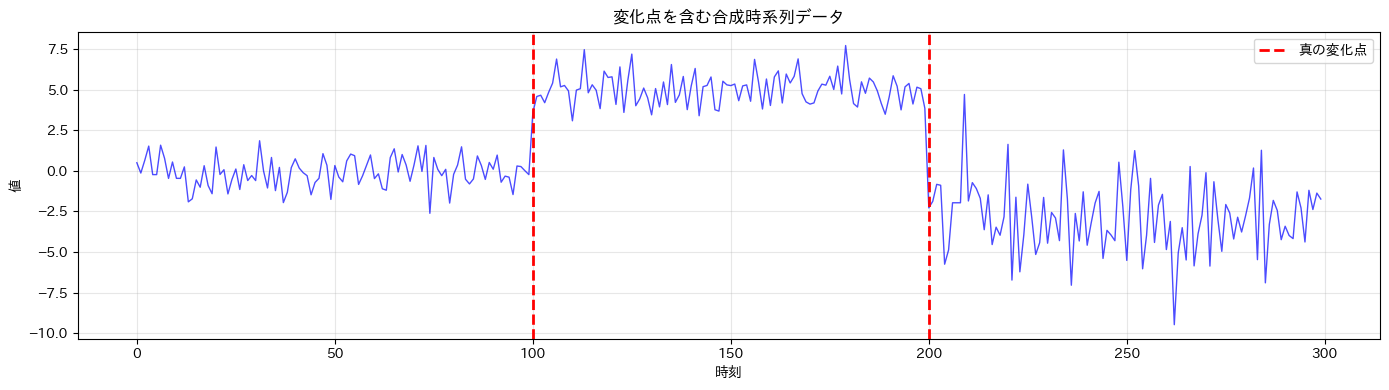

In [3]:
plt.figure(figsize=(14, 4))
plt.plot(data, 'b-', alpha=0.7, linewidth=1)
plt.axvline(100, color='r', linestyle='--', linewidth=2, label='真の変化点')
plt.axvline(200, color='r', linestyle='--', linewidth=2)
plt.xlabel('時刻')
plt.ylabel('値')
plt.title('変化点を含む合成時系列データ')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. BOCPDモデルの初期化

最初の50ポイントを使って経験ベイズ的にモデルを初期化します。

In [4]:
# データを分割
init_size = 50
init_data = data[:init_size]
stream_data = data[init_size:]

# モデルとハザード関数を初期化
model = GaussianModel()
hazard = ConstantHazard(lambda_=0.05)  # 期待ランレングス20
detector = BOCPD(model=model, hazard=hazard, max_run_length=250)

# 初期データで学習
detector.fit(init_data)

print(f"モデル: {model}")
print(f"ハザード関数: {hazard}")
print(f"\n初期化に使用したデータ数: {len(init_data)}")
print(f"処理するストリームデータ数: {len(stream_data)}")

モデル: GaussianModel(mu0=-0.2255, kappa0=1.0000, alpha0=2.0000, beta0=0.8717)
ハザード関数: ConstantHazard(lambda_=0.0500, expected_run_length=20.00)

初期化に使用したデータ数: 50
処理するストリームデータ数: 250


## 4. オンライン変化点検知

ストリーミングデータを逐次処理し、変化点を検知します。

In [5]:
# 結果を保存するリスト
results = {
    'timesteps': [],
    'values': [],
    'changepoint_probs': [],
    'run_lengths': [],
    'run_length_dists': [],
    'prediction_log_probs': []
}

detected_changepoints = []

# ストリーミングデータを処理
for t, x in enumerate(stream_data, start=init_size):
    result = detector.update(x)
    
    # 結果を記録
    results['timesteps'].append(t)
    results['values'].append(x)
    results['changepoint_probs'].append(result['changepoint_prob'])
    results['run_lengths'].append(result['most_likely_run_length'])
    results['run_length_dists'].append(result['run_length_dist'])
    results['prediction_log_probs'].append(result['prediction_log_prob'])
    
    # 変化点検知（ランレングス=1で高確率の場合）
    run_length = result['most_likely_run_length']
    run_length_dist = result['run_length_dist']
    
    if run_length == 1 and run_length_dist[1] > 0.5:
        detected_changepoints.append(t)

print(f"検知された変化点: {detected_changepoints}")
print(f"真の変化点: {true_changepoints}")

検知された変化点: [50, 100, 200]
真の変化点: [100, 200]


## 5. 結果の可視化

### 5.1 時系列データと検知された変化点

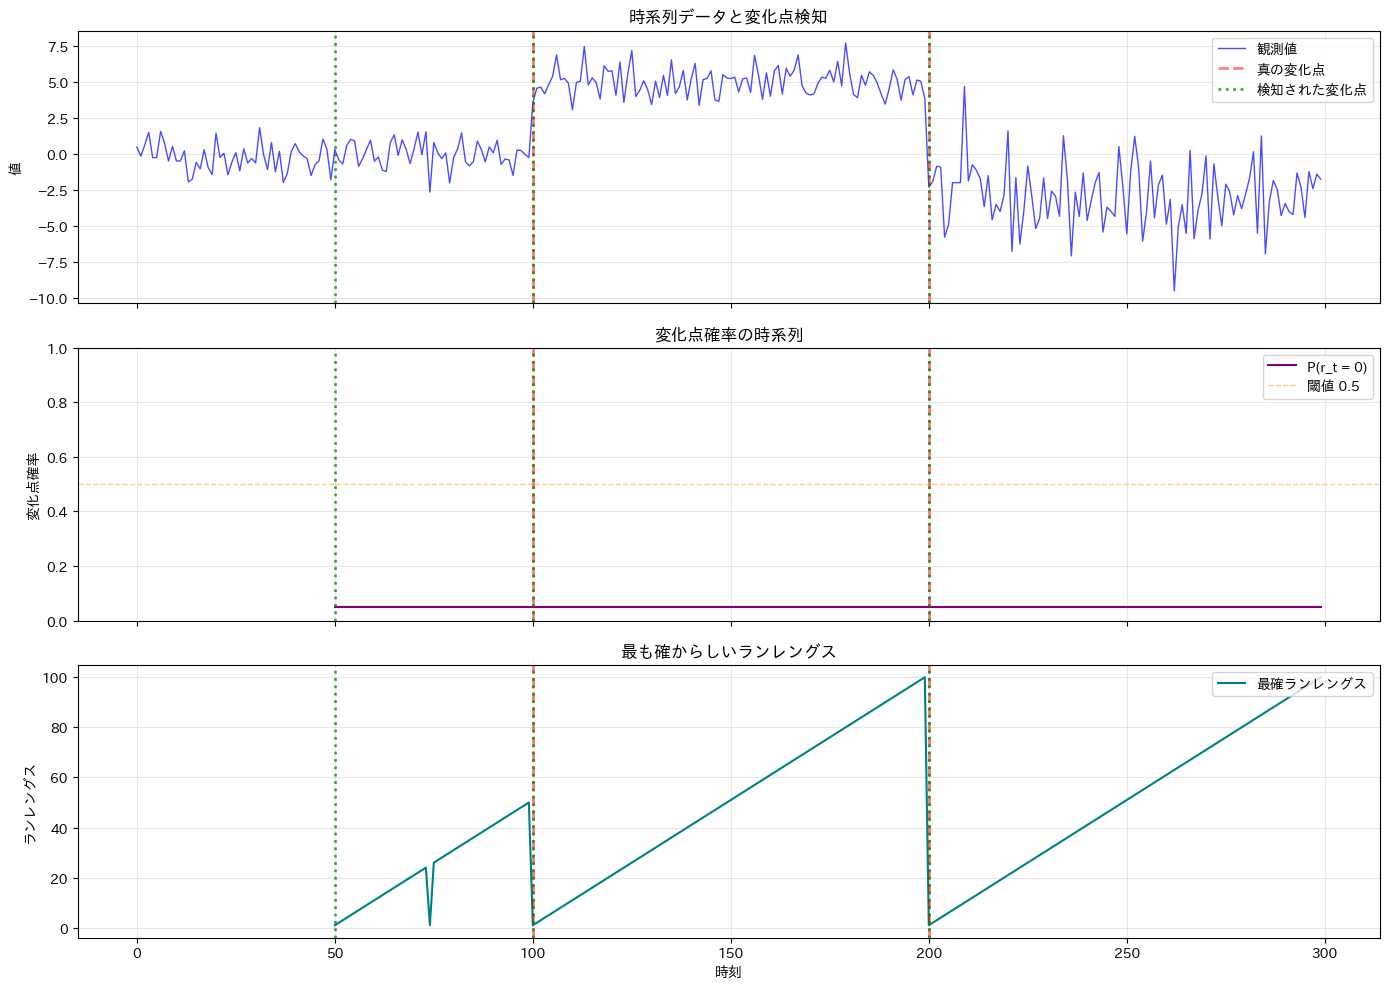

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# プロット1: 時系列データ
axes[0].plot(data, 'b-', alpha=0.7, linewidth=1, label='観測値')
for cp in true_changepoints:
    axes[0].axvline(cp, color='r', linestyle='--', linewidth=2, alpha=0.5, label='真の変化点' if cp == true_changepoints[0] else '')
for cp in detected_changepoints:
    axes[0].axvline(cp, color='g', linestyle=':', linewidth=2, alpha=0.7, label='検知された変化点' if cp == detected_changepoints[0] else '')
axes[0].set_ylabel('値')
axes[0].set_title('時系列データと変化点検知')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# プロット2: 変化点確率
axes[1].plot(results['timesteps'], results['changepoint_probs'], 'purple', linewidth=1.5, label='P(r_t = 0)')
axes[1].axhline(0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='閾値 0.5')
for cp in true_changepoints:
    axes[1].axvline(cp, color='r', linestyle='--', linewidth=2, alpha=0.5)
for cp in detected_changepoints:
    axes[1].axvline(cp, color='g', linestyle=':', linewidth=2, alpha=0.7)
axes[1].set_ylabel('変化点確率')
axes[1].set_title('変化点確率の時系列')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# プロット3: 最も確からしいランレングス
axes[2].plot(results['timesteps'], results['run_lengths'], 'teal', linewidth=1.5, label='最確ランレングス')
for cp in true_changepoints:
    axes[2].axvline(cp, color='r', linestyle='--', linewidth=2, alpha=0.5)
for cp in detected_changepoints:
    axes[2].axvline(cp, color='g', linestyle=':', linewidth=2, alpha=0.7)
axes[2].set_xlabel('時刻')
axes[2].set_ylabel('ランレングス')
axes[2].set_title('最も確からしいランレングス')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 ランレングス分布のヒートマップ

各時刻でのランレングス分布を可視化します。明るい色（黄色〜赤）ほど高確率を示します。

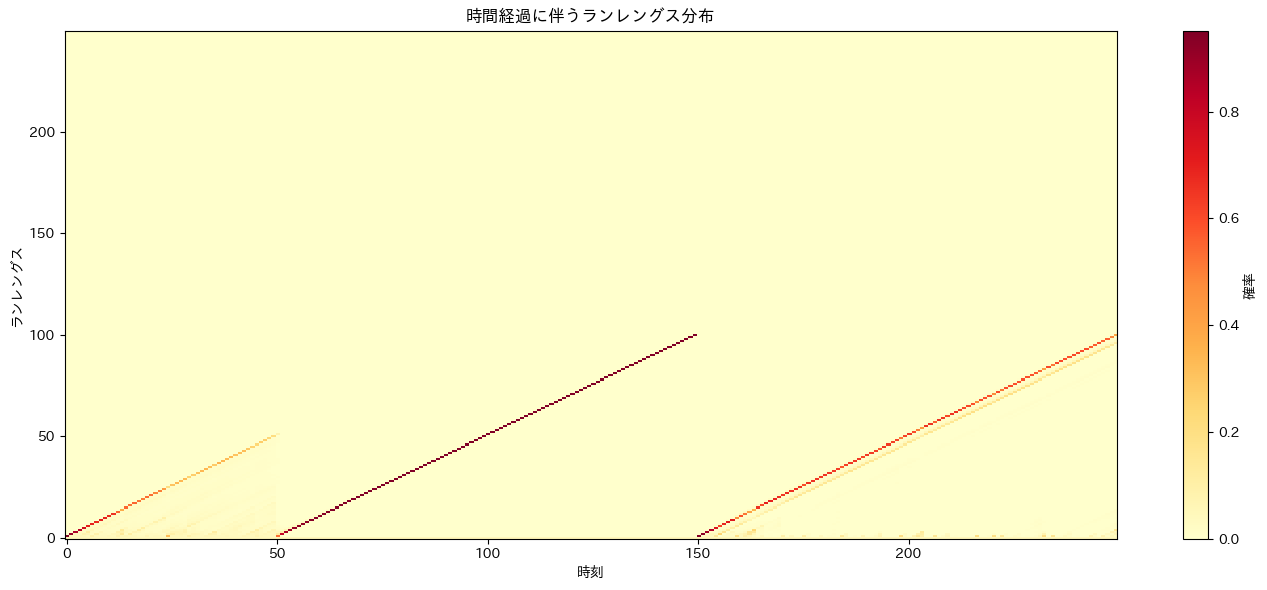

In [9]:
# ランレングス分布の履歴を使用してヒートマップを作成
fig = plot_run_length_history(
    results['run_length_dists'],
    figsize=(14, 6),
    title='時間経過に伴うランレングス分布'
)
plt.show()

### 5.3 変化点周辺の詳細分析

真の変化点周辺でのランレングス分布の変化を詳しく見てみます。

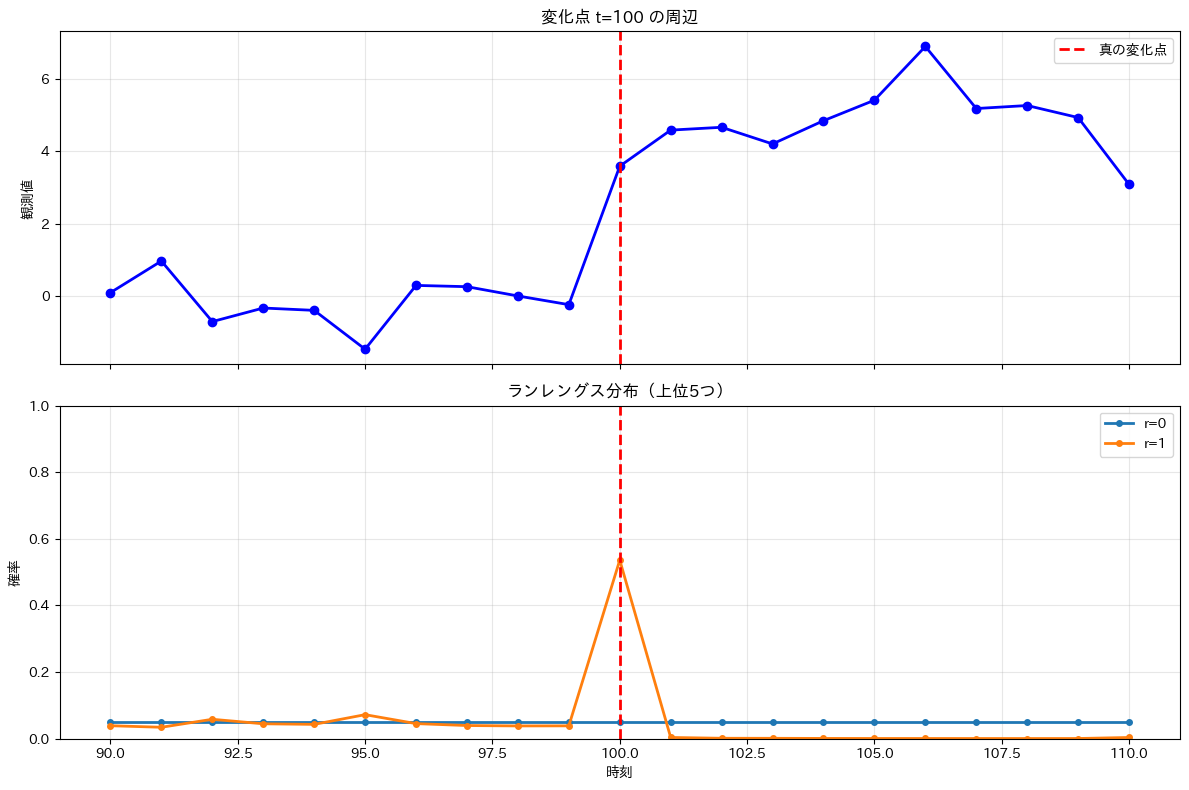

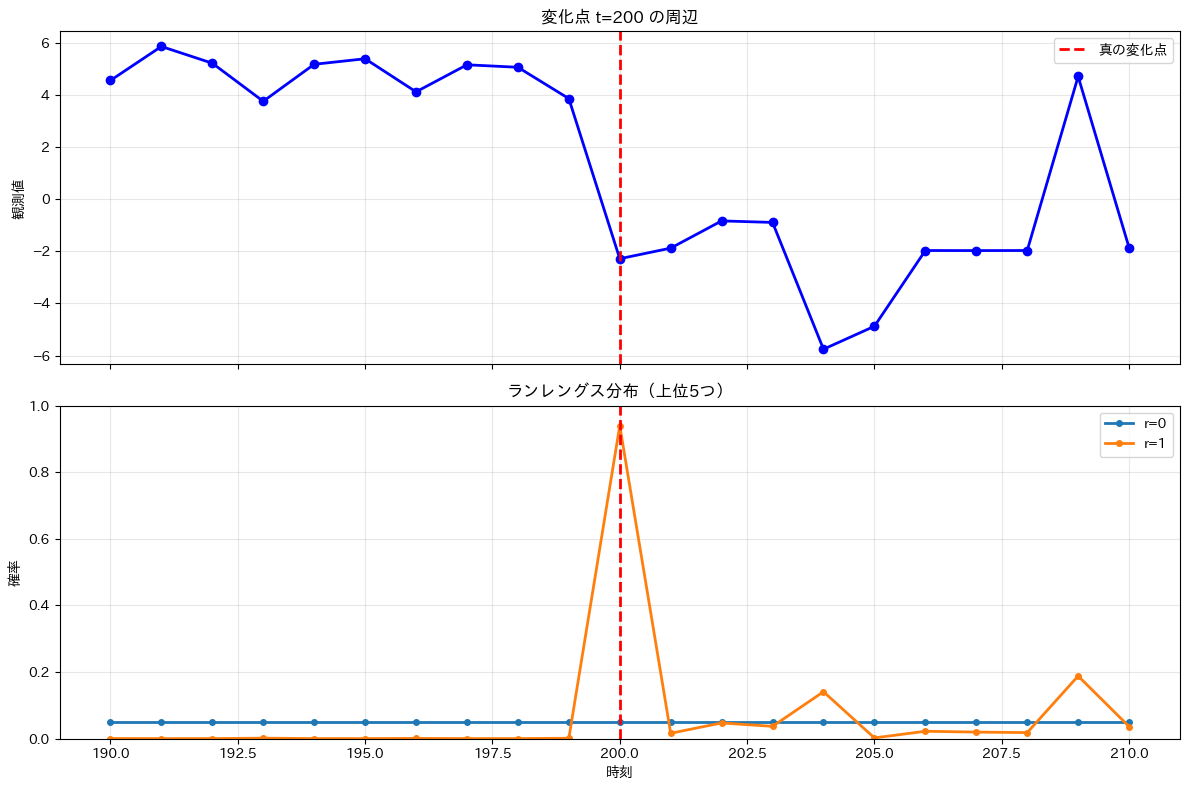

In [10]:
def plot_changepoint_detail(results, center_time, window=10, title="変化点周辺の詳細"):
    """変化点周辺の詳細をプロット"""
    # 時刻のインデックスを取得
    start_idx = max(0, center_time - init_size - window)
    end_idx = min(len(results['timesteps']), center_time - init_size + window + 1)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # プロット1: 観測値
    window_times = results['timesteps'][start_idx:end_idx]
    window_values = results['values'][start_idx:end_idx]
    axes[0].plot(window_times, window_values, 'bo-', linewidth=2, markersize=6)
    axes[0].axvline(center_time, color='r', linestyle='--', linewidth=2, label='真の変化点')
    axes[0].set_ylabel('観測値')
    axes[0].set_title(title)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # プロット2: ランレングス分布（上位5つ）
    for r in range(min(5, len(results['run_length_dists'][0]))):
        probs = [dist[r] if r < len(dist) else 0 for dist in results['run_length_dists'][start_idx:end_idx]]
        axes[1].plot(window_times, probs, 'o-', linewidth=2, markersize=4, label=f'r={r}')
    
    axes[1].axvline(center_time, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('時刻')
    axes[1].set_ylabel('確率')
    axes[1].set_title('ランレングス分布（上位5つ）')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

# 各変化点周辺を詳細に見る
for cp in true_changepoints:
    plot_changepoint_detail(results, cp, window=10, title=f'変化点 t={cp} の周辺')

## 6. 性能評価

In [11]:
def evaluate_detection(detected, true, tolerance=5):
    """変化点検知の性能を評価"""
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    
    matched_true = set()
    
    # 検知された各変化点について
    for det in detected:
        matched = False
        for true_cp in true:
            if abs(det - true_cp) <= tolerance and true_cp not in matched_true:
                tp += 1
                matched_true.add(true_cp)
                matched = True
                break
        if not matched:
            fp += 1
    
    # 検知されなかった真の変化点
    fn = len(true) - len(matched_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# 性能評価
metrics = evaluate_detection(detected_changepoints, true_changepoints, tolerance=5)

print("=" * 50)
print("変化点検知の性能評価")
print("=" * 50)
print(f"真の変化点数: {len(true_changepoints)}")
print(f"検知された変化点数: {len(detected_changepoints)}")
print(f"\nTrue Positives: {metrics['true_positives']}")
print(f"False Positives: {metrics['false_positives']}")
print(f"False Negatives: {metrics['false_negatives']}")
print(f"\nPrecision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1 Score: {metrics['f1_score']:.3f}")
print("=" * 50)

変化点検知の性能評価
真の変化点数: 2
検知された変化点数: 3

True Positives: 2
False Positives: 1
False Negatives: 0

Precision: 0.667
Recall: 1.000
F1 Score: 0.800


## 7. 予測対数確率の分析

モデルの予測性能を予測対数確率で評価します。変化点で予測が外れるため、対数確率が低下します。

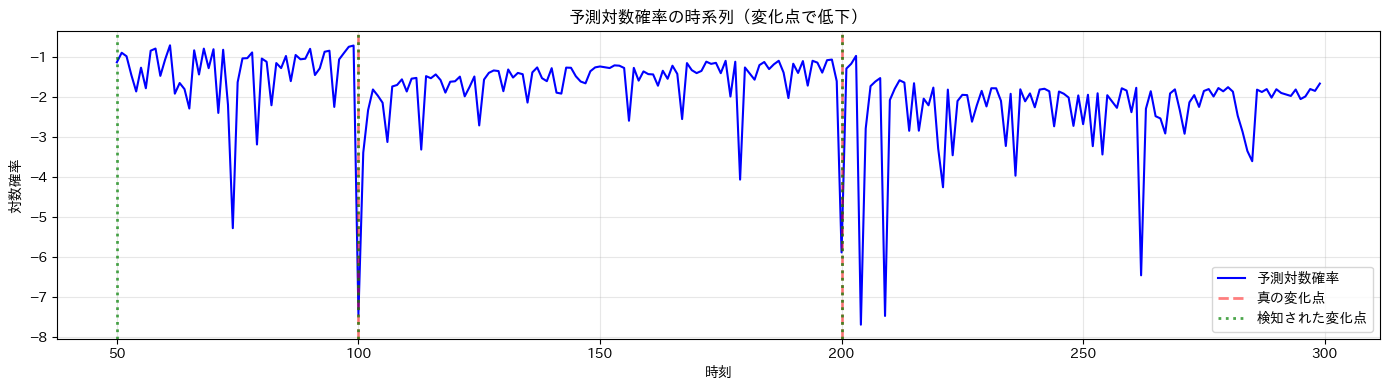

平均負の対数尤度: 1.858


In [12]:
plt.figure(figsize=(14, 4))
plt.plot(results['timesteps'], results['prediction_log_probs'], 'b-', linewidth=1.5, label='予測対数確率')
for cp in true_changepoints:
    plt.axvline(cp, color='r', linestyle='--', linewidth=2, alpha=0.5, label='真の変化点' if cp == true_changepoints[0] else '')
for cp in detected_changepoints:
    plt.axvline(cp, color='g', linestyle=':', linewidth=2, alpha=0.7, label='検知された変化点' if cp == detected_changepoints[0] else '')
plt.xlabel('時刻')
plt.ylabel('対数確率')
plt.title('予測対数確率の時系列（変化点で低下）')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 平均負の対数尤度を計算
mean_nll = -np.mean(results['prediction_log_probs'])
print(f"平均負の対数尤度: {mean_nll:.3f}")

## まとめ

このノートブックでは、BOCPDライブラリを使用して：

1. 合成データの生成と可視化
2. 経験ベイズによるモデルの初期化
3. オンライン変化点検知の実行
4. 結果の多角的な可視化
   - 時系列データと検知結果
   - 変化点確率の推移
   - ランレングス分布のヒートマップ
   - 変化点周辺の詳細分析
5. 検知性能の定量的評価
6. 予測性能の分析

を行いました。